In [8]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [9]:
#task to retrain the model with and save the results for 40 epochs, to save the output images on every 10 epochs (10,20,30,40)
#bonus task (2 points) to change the model of generator to make the quality of generated images higher with the same number of epochs

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/cats/'
#https://drive.google.com/drive/folders/1elzimVxSfa6KY7BvOhbA_fZBmO2qH3TV?usp=share_link

In [12]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [13]:
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

In [14]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [15]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [16]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

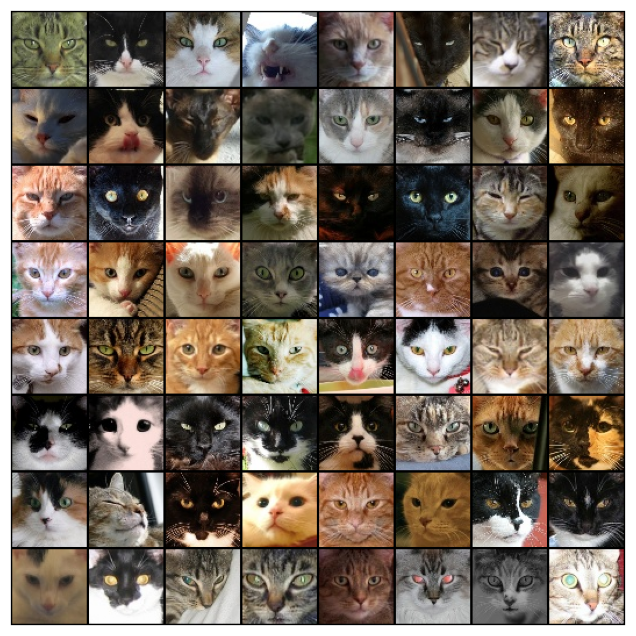

In [17]:
show_batch(train_dl)

In [18]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [20]:
train_dl = DeviceDataLoader(train_dl, device)

In [21]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [22]:
discriminator = to_device(discriminator, device)

In [23]:
latent_size = 128

In [24]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


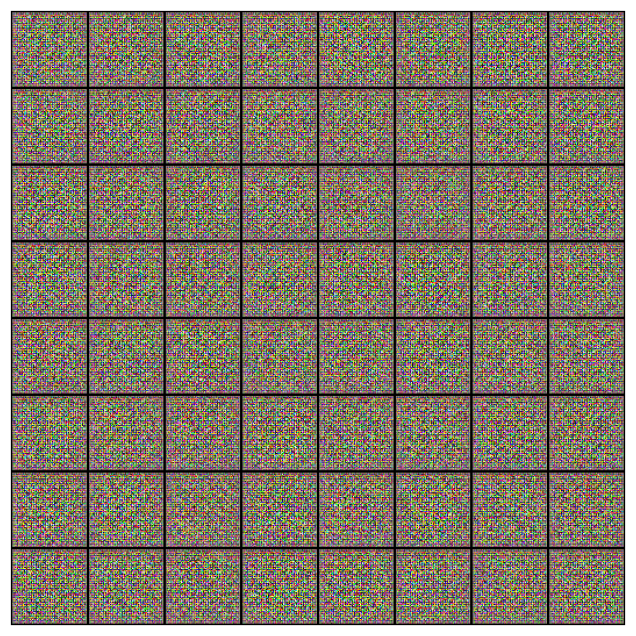

In [25]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [26]:
generator = to_device(generator, device)

In [27]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [28]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [29]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [30]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(),
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }

    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)

            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs,
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))

        # Save generated images
        if epoch == epochs - 1:
          save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [31]:
model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
lr = 0.0002
epochs = 10

In [32]:
history = fit(model, criterion, epochs, lr)

  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 7.5849, loss_d: 0.4667, real_score: 0.8514, fake_score: 0.1498


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 5.0291, loss_d: 0.5229, real_score: 0.8299, fake_score: 0.1637


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 4.0215, loss_d: 0.5856, real_score: 0.7938, fake_score: 0.1988


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 3.8058, loss_d: 0.7453, real_score: 0.7559, fake_score: 0.2429


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 4.3222, loss_d: 0.7186, real_score: 0.7680, fake_score: 0.2316


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 4.6100, loss_d: 0.6818, real_score: 0.7889, fake_score: 0.2090


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 4.6854, loss_d: 0.6505, real_score: 0.7951, fake_score: 0.2064


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 4.6492, loss_d: 0.7053, real_score: 0.7939, fake_score: 0.2046


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 4.4642, loss_d: 0.7159, real_score: 0.7888, fake_score: 0.2118


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 4.4876, loss_d: 0.6176, real_score: 0.8078, fake_score: 0.1912
Saving generated-images-0010.png


In [33]:
save_samples(epochs, fixed_latent, show=False)

Saving generated-images-0010.png


In [34]:
losses_g, losses_d, real_scores, fake_scores = history

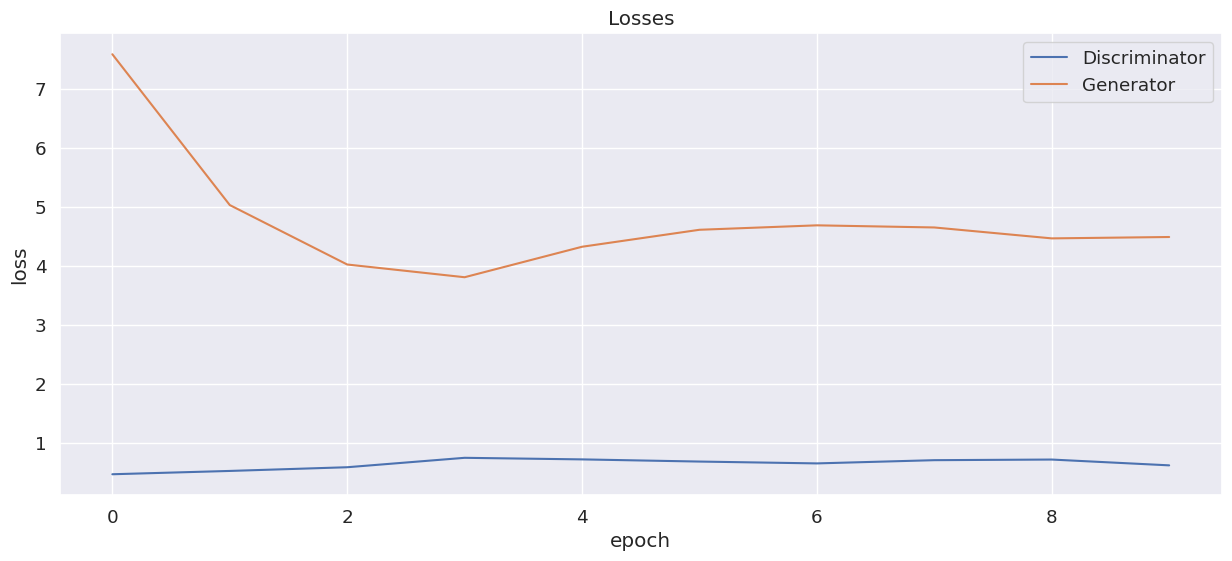

In [35]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

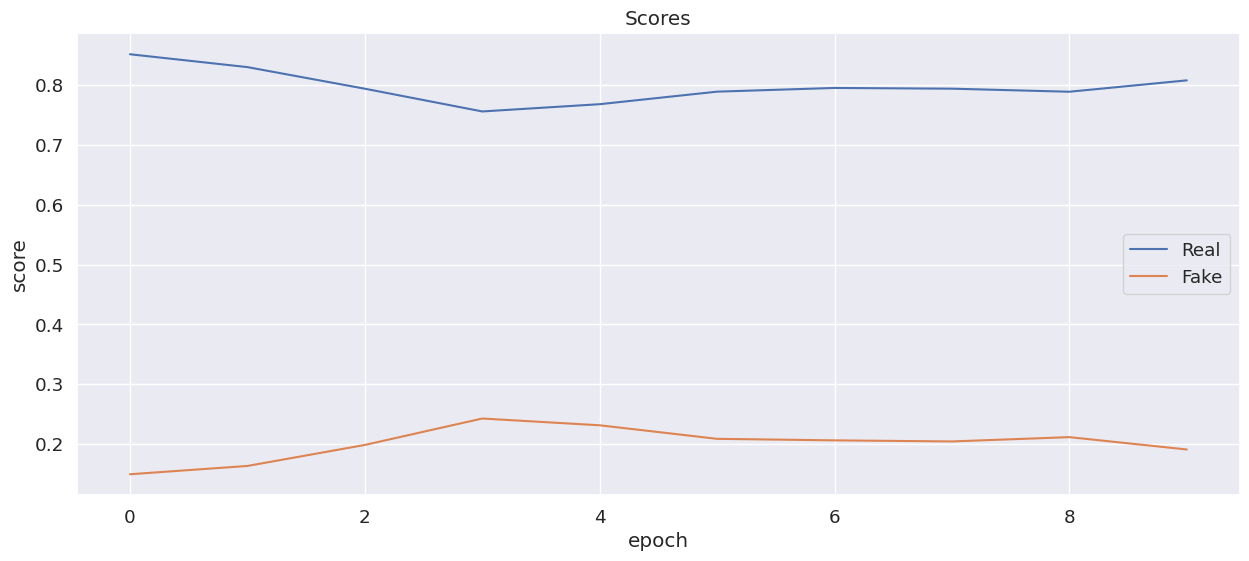

In [36]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [37]:
epochs_per_save = 10
total_epochs = 40

for epoch in range(total_epochs):
    history = fit(model, criterion, epochs_per_save, lr, start_idx=epoch * epochs_per_save + 1)
    losses_g, losses_d, real_scores, fake_scores = history
    plt.figure(figsize=(15, 6))
    plt.plot(losses_d, '-')
    plt.plot(losses_g, '-')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Discriminator', 'Generator'])
    plt.title('Losses (Epoch {})'.format(epoch * epochs_per_save + epochs_per_save))
    plt.savefig('losses_epoch_{}.png'.format(epoch * epochs_per_save + epochs_per_save))
    plt.close()

    plt.figure(figsize=(15, 6))
    plt.plot(real_scores, '-')
    plt.plot(fake_scores, '-')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.legend(['Real', 'Fake'])
    plt.title('Scores (Epoch {})'.format(epoch * epochs_per_save + epochs_per_save))
    plt.savefig('scores_epoch_{}.png'.format(epoch * epochs_per_save + epochs_per_save))
    plt.close()

    save_samples(epoch * epochs_per_save + epochs_per_save, fixed_latent, show=False)


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 4.9820, loss_d: 0.5409, real_score: 0.8353, fake_score: 0.1701


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 4.8685, loss_d: 0.5686, real_score: 0.8271, fake_score: 0.1705


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 5.1126, loss_d: 0.4826, real_score: 0.8438, fake_score: 0.1546


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 5.0449, loss_d: 0.5177, real_score: 0.8421, fake_score: 0.1575


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 5.0923, loss_d: 0.5017, real_score: 0.8479, fake_score: 0.1525


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 4.9737, loss_d: 0.4887, real_score: 0.8462, fake_score: 0.1511


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 5.0892, loss_d: 0.4805, real_score: 0.8502, fake_score: 0.1505


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 5.1958, loss_d: 0.4575, real_score: 0.8585, fake_score: 0.1382


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 4.9640, loss_d: 0.4774, real_score: 0.8554, fake_score: 0.1442


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 5.0863, loss_d: 0.4401, real_score: 0.8620, fake_score: 0.1379
Saving generated-images-0010.png
Saving generated-images-0010.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 5.0732, loss_d: 0.3944, real_score: 0.8758, fake_score: 0.1295


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 5.5897, loss_d: 0.4094, real_score: 0.8744, fake_score: 0.1273


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 5.6100, loss_d: 0.3869, real_score: 0.8745, fake_score: 0.1220


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 5.5426, loss_d: 0.3679, real_score: 0.8834, fake_score: 0.1147


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 5.5942, loss_d: 0.3975, real_score: 0.8838, fake_score: 0.1154


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 5.6573, loss_d: 0.3463, real_score: 0.8926, fake_score: 0.1072


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 6.0446, loss_d: 0.3170, real_score: 0.9015, fake_score: 0.1012


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 6.1099, loss_d: 0.3340, real_score: 0.9031, fake_score: 0.0949


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 5.9926, loss_d: 0.3646, real_score: 0.8947, fake_score: 0.1017


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 5.8864, loss_d: 0.3395, real_score: 0.9047, fake_score: 0.0966
Saving generated-images-0020.png
Saving generated-images-0020.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 6.5401, loss_d: 0.1942, real_score: 0.9398, fake_score: 0.0640


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 6.0143, loss_d: 0.4381, real_score: 0.8969, fake_score: 0.0998


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 6.0876, loss_d: 0.3080, real_score: 0.9095, fake_score: 0.0902


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 6.1716, loss_d: 0.3051, real_score: 0.9110, fake_score: 0.0881


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 6.5210, loss_d: 0.2315, real_score: 0.9290, fake_score: 0.0705


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 6.7514, loss_d: 0.3164, real_score: 0.9106, fake_score: 0.0880


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 6.6793, loss_d: 0.1440, real_score: 0.9509, fake_score: 0.0516


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 6.0631, loss_d: 0.3983, real_score: 0.8944, fake_score: 0.1017


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 5.9435, loss_d: 0.3179, real_score: 0.9081, fake_score: 0.0903


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 6.2571, loss_d: 0.2830, real_score: 0.9236, fake_score: 0.0763
Saving generated-images-0030.png
Saving generated-images-0030.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 6.2110, loss_d: 0.2868, real_score: 0.9283, fake_score: 0.0711


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 6.4433, loss_d: 0.2785, real_score: 0.9295, fake_score: 0.0675


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 6.2026, loss_d: 0.2318, real_score: 0.9307, fake_score: 0.0728


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 6.8464, loss_d: 0.3308, real_score: 0.9169, fake_score: 0.0814


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 6.6481, loss_d: 0.2034, real_score: 0.9421, fake_score: 0.0578


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 8.3110, loss_d: 0.0667, real_score: 0.9767, fake_score: 0.0297


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 6.5484, loss_d: 0.4260, real_score: 0.9081, fake_score: 0.0848


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 6.1677, loss_d: 0.2422, real_score: 0.9327, fake_score: 0.0670


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 7.0343, loss_d: 0.2764, real_score: 0.9263, fake_score: 0.0719


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 6.3151, loss_d: 0.2151, real_score: 0.9361, fake_score: 0.0646
Saving generated-images-0040.png
Saving generated-images-0040.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 7.2134, loss_d: 0.2515, real_score: 0.9357, fake_score: 0.0642


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 7.3184, loss_d: 0.2814, real_score: 0.9340, fake_score: 0.0690


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 6.9263, loss_d: 0.2388, real_score: 0.9362, fake_score: 0.0625


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 6.8324, loss_d: 0.2436, real_score: 0.9415, fake_score: 0.0597


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 7.5547, loss_d: 0.0357, real_score: 0.9849, fake_score: 0.0180


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 10.1602, loss_d: 0.1855, real_score: 0.9571, fake_score: 0.0418


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 7.9507, loss_d: 0.0845, real_score: 0.9656, fake_score: 0.0344


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 7.5933, loss_d: 0.2693, real_score: 0.9359, fake_score: 0.0610


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 7.4910, loss_d: 0.2389, real_score: 0.9456, fake_score: 0.0537


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 6.6663, loss_d: 0.1410, real_score: 0.9578, fake_score: 0.0441
Saving generated-images-0050.png
Saving generated-images-0050.png


  0%|          | 0/140 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Generated Images

Image 10:


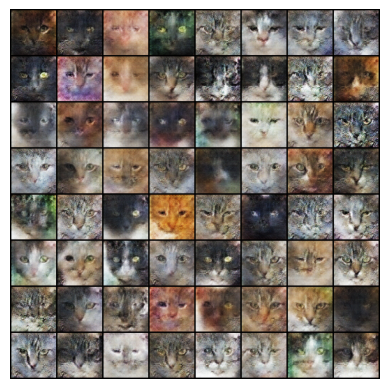

Image 20:


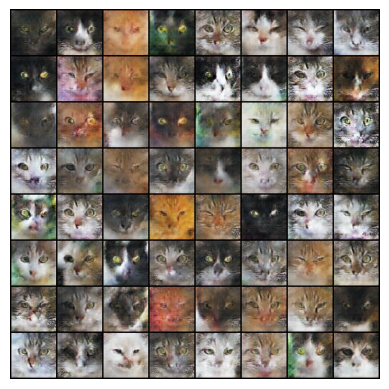

Image 30:


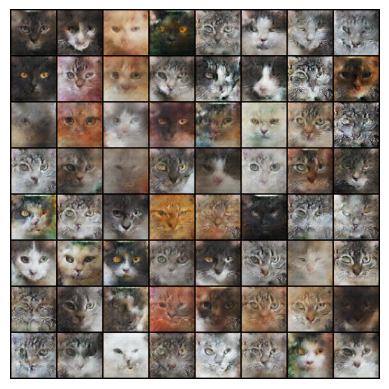

Image 40:


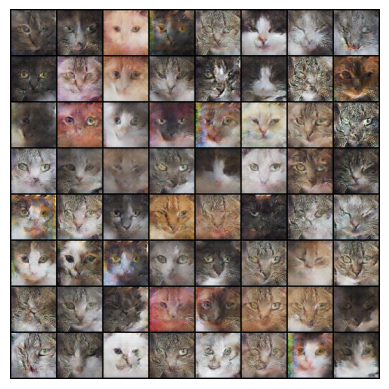

In [52]:
from IPython.display import Image

for i in range(10, 41, 10):
  print(f"Image {i}:")
  img1 = plt.imread(f"/content/generated/generated-images-{i:04d}.png")
  plt.imshow(img1)
  plt.axis('off')
  plt.show()
  # print(f"Losses of image {i}:")
  # img2 = plt.imread(f"/content/losses_epoch_{i:04d}.png")
  # plt.imshow(img2)
  # print(f"Scores of image {i}:")
  # img3 = plt.imread(f"/content/scores_epoch_{i:04d}.png")
  # plt.imshow(img3)